# Ensemble Strategy: Specialist Models for Confused Classes

**Strategy:** Train 2 specialist models (Motion & Face) with multi-GPU (2x T4) and combine with Global Model.

- **Global Model:** 51 classes (pre-trained, loaded from checkpoint)
- **Specialist A (Motion):** jump, run, climb_stairs + Others (4 classes)
- **Specialist B (Face):** smile, talk, laugh + Others (4 classes)

## 1. Configuration

In [16]:
# =================== CONFIGURATION ===================
# Specialist Targets
SPECIALIST_A_TARGETS = ['jump', 'run', 'climb_stairs']
SPECIALIST_B_TARGETS = ['smile', 'talk', 'laugh']

# Model Config
NUM_FRAMES = 8
IMG_SIZE = 224
RESIZE_SIZE = 256

# Training Config
BATCH_SIZE = 8
ACCUM_STEPS = 4
EPOCHS_P1 = 10
EPOCHS_P2 = 5
LR_P1 = 5e-5
LR_P2 = 1e-6
WEIGHT_DECAY = 0.05
WARMUP_RATIO = 0.1
MIXUP_ALPHA = 0.8
LABEL_SMOOTHING_EPS = 0.1

# Undersampling: Count(Others) = UNDERSAMPLE_RATIO * Sum(Targets)
UNDERSAMPLE_RATIO = 1.0

# Ensemble Fusion Weight
FUSION_WEIGHT = 1.0

# Paths
PATH_DATA_TRAIN = '/kaggle/input/action-video/data/data_train'
PATH_DATA_TEST = '/kaggle/input/action-video/data/test'
TEST_LABELS_URL = '1Xv2CWOqdBj3kt0rkNJKRsodSIEd3-wX_'

# Global Model Checkpoint (FILL THIS PATH)
GLOBAL_MODEL_CKPT = "./videomae_final_best"  # <-- PUT YOUR GLOBAL MODEL PATH HERE

print('Configuration loaded.')

Configuration loaded.


## 2. Imports & Setup

In [17]:
import os, gc, random, warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from pathlib import Path
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from transformers import VideoMAEForVideoClassification
from transformers import get_cosine_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

# Multi-GPU Setup
N_GPUS = torch.cuda.device_count()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {DEVICE}, Available GPUs: {N_GPUS}')

MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

Device: cuda, Available GPUs: 2


## 3. Dataset Classes

In [18]:
class VideoDataset(Dataset):
    """Base dataset with consistent spatial augmentation."""
    def __init__(self, root, num_frames=16, consistent_aug=True):
        self.root = Path(root)
        self.num_frames = num_frames
        self.consistent_aug = consistent_aug
        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class_to_idx = {c: i for i, c in enumerate(self.classes)}
        self.samples = []
        for cls in self.classes:
            for vid in (self.root / cls).iterdir():
                if vid.is_dir():
                    self.samples.append((vid, self.class_to_idx[cls]))
        print(f'Loaded {len(self.samples)} videos, {len(self.classes)} classes')
    
    def __len__(self): return len(self.samples)
    
    def __getitem__(self, idx):
        vid_dir, label = self.samples[idx]
        files = sorted(vid_dir.glob('*.jpg'))
        indices = torch.linspace(0, len(files)-1, self.num_frames).long()
        frames = [Image.open(files[i]).convert('RGB') for i in indices]
        frames = [TF.resize(img, RESIZE_SIZE) for img in frames]
        
        if self.consistent_aug:
            i, j, h, w = T.RandomResizedCrop.get_params(frames[0], (0.8, 1.0), (0.75, 1.33))
            do_flip = random.random() > 0.5
            processed = []
            for img in frames:
                img = TF.resized_crop(img, i, j, h, w, (IMG_SIZE, IMG_SIZE))
                if do_flip: img = TF.hflip(img)
                processed.append(TF.normalize(TF.to_tensor(img), MEAN, STD))
        else:
            processed = [TF.normalize(TF.to_tensor(TF.center_crop(img, IMG_SIZE)), MEAN, STD) for img in frames]
        return torch.stack(processed), label


class TestDataset(Dataset):
    """Test dataset with center crop."""
    def __init__(self, root, num_frames=16):
        self.root = Path(root)
        self.num_frames = num_frames
        self.samples = [(d, int(d.name)) for d in self.root.iterdir() if d.is_dir()]
        self.samples.sort(key=lambda x: x[1])
    
    def __len__(self): return len(self.samples)
    
    def __getitem__(self, idx):
        vid_dir, vid_id = self.samples[idx]
        files = sorted(vid_dir.glob('*.jpg'))
        indices = torch.linspace(0, len(files)-1, self.num_frames).long()
        frames = []
        for i in indices:
            img = Image.open(files[i]).convert('RGB')
            img = TF.resize(img, RESIZE_SIZE)
            img = TF.center_crop(img, IMG_SIZE)
            frames.append(TF.normalize(TF.to_tensor(img), MEAN, STD))
        return torch.stack(frames), vid_id

print('Dataset classes defined.')

Dataset classes defined.


## 4. Specialist Dataset (Label Remapping + Undersampling)

In [19]:
class SpecialistDataset(Dataset):
    """
    Wraps VideoDataset for specialist training.
    - Target classes -> 0..N-1
    - All other classes -> N (Others)
    - Undersampling applied to balance Others
    """
    def __init__(self, base_dataset, target_classes, undersample_ratio=1.0):
        self.base_dataset = base_dataset
        self.target_classes = target_classes
        self.num_targets = len(target_classes)
        self.target_to_new_idx = {cls: i for i, cls in enumerate(target_classes)}
        self.others_idx = self.num_targets
        
        target_samples, others_samples = [], []
        for orig_idx, (vid_path, orig_label) in enumerate(base_dataset.samples):
            orig_class = base_dataset.classes[orig_label]
            if orig_class in self.target_to_new_idx:
                target_samples.append((orig_idx, self.target_to_new_idx[orig_class]))
            else:
                others_samples.append((orig_idx, self.others_idx))
        
        # Undersampling
        max_others = int(len(target_samples) * undersample_ratio)
        if len(others_samples) > max_others:
            random.shuffle(others_samples)
            others_samples = others_samples[:max_others]
            print(f'  Undersampled Others: {len(others_samples)}')
        
        self.samples = target_samples + others_samples
        random.shuffle(self.samples)
        self.classes = target_classes + ['Others']
        
        counts = Counter([s[1] for s in self.samples])
        print(f'  Specialist Dataset: {len(self.samples)} samples')
        for i, cls in enumerate(self.classes):
            print(f'    {cls}: {counts.get(i, 0)}')
    
    def __len__(self): return len(self.samples)
    
    def __getitem__(self, idx):
        orig_idx, new_label = self.samples[idx]
        video, _ = self.base_dataset[orig_idx]
        return video, new_label

print('SpecialistDataset defined.')

SpecialistDataset defined.


## 5. Model Factory (Multi-GPU with DataParallel)

In [20]:
def create_model(num_classes, num_frames=16, use_dp=True):
    """Create VideoMAE model with optional DataParallel."""
    model = VideoMAEForVideoClassification.from_pretrained(
        'MCG-NJU/videomae-base-finetuned-kinetics',
        num_labels=num_classes,
        ignore_mismatched_sizes=True,
        num_frames=num_frames
    )
    if use_dp and N_GPUS > 1:
        model = nn.DataParallel(model)
        print(f'Created VideoMAE with DataParallel ({N_GPUS} GPUs)')
    else:
        print(f'Created VideoMAE on single GPU')
    return model.to(DEVICE)

print('Model factory defined.')

Model factory defined.


## 6. Mixup Augmentation

In [21]:
class MixupCollate:
    def __init__(self, num_classes, alpha=0.8):
        self.num_classes = num_classes
        self.alpha = alpha
    
    def __call__(self, batch):
        inputs, targets = torch.utils.data.default_collate(batch)
        bs = inputs.size(0)
        lam = np.random.beta(self.alpha, self.alpha)
        index = torch.randperm(bs)
        inputs = lam * inputs + (1 - lam) * inputs[index]
        targets_oh = F.one_hot(targets, self.num_classes).float()
        targets = lam * targets_oh + (1 - lam) * targets_oh[index]
        return inputs, targets

print('Mixup defined.')

Mixup defined.


## 7. Training Functions

In [22]:
def train_epoch(model, loader, optimizer, scheduler, scaler, use_mixup=False, label_smoothing=0.0):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    pbar = tqdm(loader, desc='Train', leave=False)
    optimizer.zero_grad()
    
    for step, (inputs, targets) in enumerate(pbar):
        inputs = inputs.to(DEVICE)
        targets = targets.to(DEVICE)
        
        with torch.amp.autocast('cuda'):
            out = model(inputs)
            logits = out.logits if hasattr(out, 'logits') else out
            
            if use_mixup:
                loss = -torch.sum(targets * F.log_softmax(logits, dim=1), dim=1).mean()
                true_labels = targets.argmax(1)
            else:
                loss = F.cross_entropy(logits, targets, label_smoothing=label_smoothing)
                true_labels = targets
        
        correct += (logits.argmax(1) == true_labels).sum().item()
        total += inputs.size(0)
        
        scaler.scale(loss / ACCUM_STEPS).backward()
        if (step + 1) % ACCUM_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            if scheduler: scheduler.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{total_loss/(step+1):.4f}', 'acc': f'{correct/total:.4f}'})
    
    return total_loss / (step+1), correct / total

print('Training functions defined.')

Training functions defined.


## 8. Specialist Training Pipeline

In [23]:
def train_specialist(name, target_classes, base_ds):
    print(f'\n{"="*60}')
    print(f'TRAINING SPECIALIST: {name.upper()}')
    print(f'Targets: {target_classes}')
    print(f'{"="*60}')
    
    spec_ds = SpecialistDataset(base_ds, target_classes, UNDERSAMPLE_RATIO)
    num_classes = len(spec_ds.classes)
    model = create_model(num_classes, NUM_FRAMES, use_dp=(N_GPUS > 1))
    
    # Phase 1 DataLoader with Mixup
    mixup = MixupCollate(num_classes, MIXUP_ALPHA)
    loader_p1 = DataLoader(spec_ds, BATCH_SIZE * N_GPUS, shuffle=True, num_workers=2, collate_fn=mixup, drop_last=True)
    loader_p2 = DataLoader(spec_ds, BATCH_SIZE * N_GPUS, shuffle=True, num_workers=2, drop_last=True)
    
    history = []
    best_acc = 0.0
    scaler = torch.amp.GradScaler()
    
    # Phase 1
    print(f'\n--- Phase 1: Mixup ({EPOCHS_P1} epochs, LR={LR_P1}) ---')
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P1, weight_decay=WEIGHT_DECAY)
    total_steps = len(loader_p1) * EPOCHS_P1 // ACCUM_STEPS
    scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * WARMUP_RATIO), total_steps)
    
    for ep in range(1, EPOCHS_P1 + 1):
        loss, acc = train_epoch(model, loader_p1, optimizer, scheduler, scaler, use_mixup=True)
        history.append({'epoch': ep, 'phase': 1, 'loss': loss, 'acc': acc})
        status = ''
        if acc > best_acc:
            best_acc = acc
            state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state, f'specialist_{name}_best_p1.pt')
            status = '>>> BEST'
        print(f'Ep {ep}/{EPOCHS_P1}: L={loss:.4f} Acc={acc:.4f} {status}')
        gc.collect(); torch.cuda.empty_cache()
    
    # Phase 2
    print(f'\n--- Phase 2: Label Smoothing ({EPOCHS_P2} epochs, LR={LR_P2}) ---')
    state = torch.load(f'specialist_{name}_best_p1.pt')
    if isinstance(model, nn.DataParallel): model.module.load_state_dict(state)
    else: model.load_state_dict(state)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR_P2, weight_decay=WEIGHT_DECAY)
    total_steps = len(loader_p2) * EPOCHS_P2 // ACCUM_STEPS
    scheduler = get_cosine_schedule_with_warmup(optimizer, int(total_steps * WARMUP_RATIO), total_steps)
    scaler = torch.amp.GradScaler()
    
    for ep in range(1, EPOCHS_P2 + 1):
        loss, acc = train_epoch(model, loader_p2, optimizer, scheduler, scaler, label_smoothing=LABEL_SMOOTHING_EPS)
        history.append({'epoch': EPOCHS_P1 + ep, 'phase': 2, 'loss': loss, 'acc': acc})
        status = ''
        if acc > best_acc:
            best_acc = acc
            state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state, f'specialist_{name}_best.pt')
            status = '>>> BEST'
        print(f'P2 Ep {ep}/{EPOCHS_P2}: L={loss:.4f} Acc={acc:.4f} {status}')
        gc.collect(); torch.cuda.empty_cache()
    
    # Load best
    best_path = f'specialist_{name}_best.pt' if os.path.exists(f'specialist_{name}_best.pt') else f'specialist_{name}_best_p1.pt'
    if isinstance(model, nn.DataParallel): model.module.load_state_dict(torch.load(best_path))
    else: model.load_state_dict(torch.load(best_path))
    
    print(f'\n✓ Specialist {name} complete. Best Acc: {best_acc:.4f}')
    return model, history, spec_ds.classes

print('Training pipeline defined.')

Training pipeline defined.


## 9. Load Base Dataset & Train Specialists

In [24]:
print('Loading base dataset...')
base_ds = VideoDataset(PATH_DATA_TRAIN, NUM_FRAMES, consistent_aug=True)
MAIN_CLASSES = base_ds.classes
print(f'Classes: {len(MAIN_CLASSES)}')

Loading base dataset...
Loaded 6254 videos, 51 classes
Classes: 51


In [25]:
# Train Specialist A (Motion)
spec_A_model, hist_A, classes_A = train_specialist('motion', SPECIALIST_A_TARGETS, base_ds)


TRAINING SPECIALIST: MOTION
Targets: ['jump', 'run', 'climb_stairs']
  Undersampled Others: 465
  Specialist Dataset: 930 samples
    jump: 141
    run: 222
    climb_stairs: 102
    Others: 465


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Created VideoMAE with DataParallel (2 GPUs)

--- Phase 1: Mixup (10 epochs, LR=5e-05) ---


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 1/10: L=1.2620 Acc=0.4364 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 2/10: L=0.9056 Acc=0.6692 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 3/10: L=0.7233 Acc=0.8006 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 4/10: L=0.6177 Acc=0.8545 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 5/10: L=0.5638 Acc=0.8825 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 6/10: L=0.4992 Acc=0.8933 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 7/10: L=0.5465 Acc=0.8869 


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 8/10: L=0.4925 Acc=0.8879 


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 9/10: L=0.4582 Acc=0.9235 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

Ep 10/10: L=0.4623 Acc=0.9095 

--- Phase 2: Label Smoothing (5 epochs, LR=1e-06) ---


Train:   0%|          | 0/58 [00:00<?, ?it/s]

P2 Ep 1/5: L=0.4036 Acc=0.9860 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

P2 Ep 2/5: L=0.3991 Acc=0.9903 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

P2 Ep 3/5: L=0.3944 Acc=0.9925 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

P2 Ep 4/5: L=0.3896 Acc=0.9935 >>> BEST


Train:   0%|          | 0/58 [00:00<?, ?it/s]

P2 Ep 5/5: L=0.3913 Acc=0.9957 >>> BEST

✓ Specialist motion complete. Best Acc: 0.9957


In [26]:
# Train Specialist B (Face)
spec_B_model, hist_B, classes_B = train_specialist('face', SPECIALIST_B_TARGETS, base_ds)


TRAINING SPECIALIST: FACE
Targets: ['smile', 'talk', 'laugh']
  Undersampled Others: 318
  Specialist Dataset: 636 samples
    smile: 90
    talk: 110
    laugh: 118
    Others: 318


Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Created VideoMAE with DataParallel (2 GPUs)

--- Phase 1: Mixup (10 epochs, LR=5e-05) ---


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 1/10: L=1.2259 Acc=0.4519 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 2/10: L=0.8478 Acc=0.7356 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 3/10: L=0.6670 Acc=0.8526 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 4/10: L=0.5226 Acc=0.8942 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 5/10: L=0.4946 Acc=0.9103 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 6/10: L=0.4627 Acc=0.9087 


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 7/10: L=0.4048 Acc=0.9471 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 8/10: L=0.4744 Acc=0.9038 


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 9/10: L=0.4184 Acc=0.9199 


Train:   0%|          | 0/39 [00:00<?, ?it/s]

Ep 10/10: L=0.4255 Acc=0.9054 

--- Phase 2: Label Smoothing (5 epochs, LR=1e-06) ---


Train:   0%|          | 0/39 [00:00<?, ?it/s]

P2 Ep 1/5: L=0.4047 Acc=0.9952 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

P2 Ep 2/5: L=0.3980 Acc=0.9952 


Train:   0%|          | 0/39 [00:00<?, ?it/s]

P2 Ep 3/5: L=0.3943 Acc=0.9968 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

P2 Ep 4/5: L=0.3907 Acc=0.9984 >>> BEST


Train:   0%|          | 0/39 [00:00<?, ?it/s]

P2 Ep 5/5: L=0.3916 Acc=1.0000 >>> BEST

✓ Specialist face complete. Best Acc: 1.0000


## 10. Learning Curves

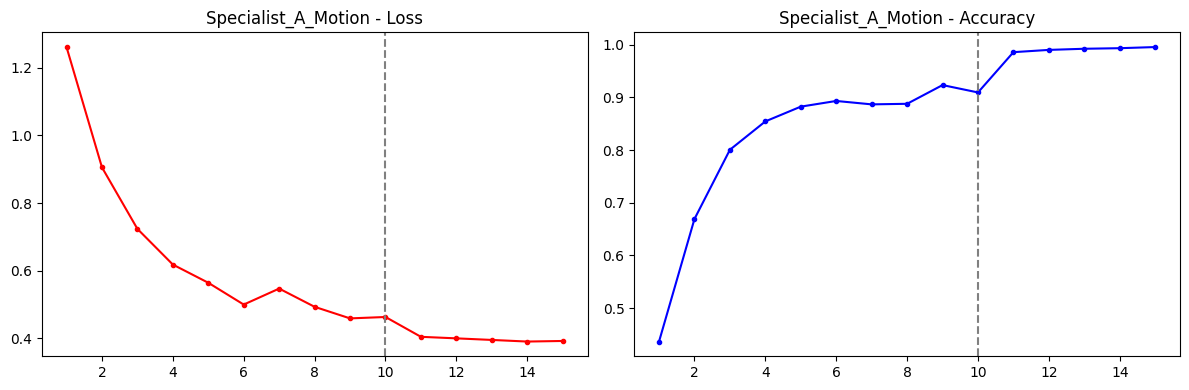

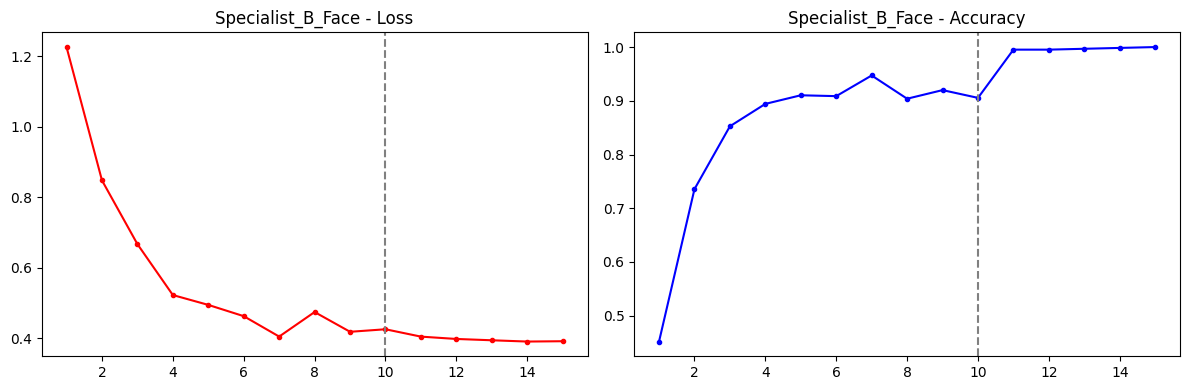

In [27]:
def plot_curves(hist, title):
    df = pd.DataFrame(hist)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(df['epoch'], df['loss'], 'r-o', ms=3)
    ax[0].axvline(x=EPOCHS_P1, color='gray', ls='--')
    ax[0].set_title(f'{title} - Loss')
    ax[1].plot(df['epoch'], df['acc'], 'b-o', ms=3)
    ax[1].axvline(x=EPOCHS_P1, color='gray', ls='--')
    ax[1].set_title(f'{title} - Accuracy')
    plt.tight_layout(); plt.savefig(f'curves_{title}.png', dpi=150); plt.show()

plot_curves(hist_A, 'Specialist_A_Motion')
plot_curves(hist_B, 'Specialist_B_Face')

## 11. Load Global Model

In [29]:
print("Loading Global Model (HF)...")
global_model = VideoMAEForVideoClassification.from_pretrained(
    GLOBAL_MODEL_CKPT
).to(DEVICE)

global_model.eval()

print("Global Model loaded.")


Loading Global Model (HF)...
Global Model loaded.


In [30]:
# print('Loading Global Model...')
# global_model = create_model(len(MAIN_CLASSES), NUM_FRAMES, use_dp=False)

# if GLOBAL_MODEL_CKPT and os.path.exists(GLOBAL_MODEL_CKPT):
#     global_model.load_state_dict(torch.load(GLOBAL_MODEL_CKPT))
#     print(f'✓ Loaded: {GLOBAL_MODEL_CKPT}')
# else:
#     print('⚠ WARNING: GLOBAL_MODEL_CKPT not set or not found!')

# global_model.eval()

## 12. Ensemble Inference

In [31]:
def get_indices(main_classes, targets):
    return [main_classes.index(c) for c in targets if c in main_classes]

@torch.no_grad()
def ensemble_predict(global_m, spec_A, spec_B, video):
    """Ensemble prediction: Global + Specialist A + Specialist B."""
    idx_A = get_indices(MAIN_CLASSES, SPECIALIST_A_TARGETS)
    idx_B = get_indices(MAIN_CLASSES, SPECIALIST_B_TARGETS)
    
    # Global logits
    out_g = global_m(video)
    logits = (out_g.logits if hasattr(out_g, 'logits') else out_g).clone()
    
    # Specialist A logits
    out_a = spec_A(video)
    logits_a = out_a.logits if hasattr(out_a, 'logits') else out_a
    for i, main_idx in enumerate(idx_A):
        logits[:, main_idx] += FUSION_WEIGHT * logits_a[:, i]
    
    # Specialist B logits
    out_b = spec_B(video)
    logits_b = out_b.logits if hasattr(out_b, 'logits') else out_b
    for i, main_idx in enumerate(idx_B):
        logits[:, main_idx] += FUSION_WEIGHT * logits_b[:, i]
    
    return logits

print('Ensemble logic defined.')

Ensemble logic defined.


## 13. Run Evaluation

In [32]:
# Load test labels
import gdown
gdown.download(f'https://drive.google.com/uc?id={TEST_LABELS_URL}', 'test_labels.csv', quiet=True)
gt_df = pd.read_csv('test_labels.csv')
gt_dict = dict(zip(gt_df['id'].astype(str), gt_df['class']))
print(f'Loaded {len(gt_dict)} test labels.')

Loaded 510 test labels.


In [33]:
test_ds = TestDataset(PATH_DATA_TEST, NUM_FRAMES)
test_loader = DataLoader(test_ds, BATCH_SIZE, shuffle=False, num_workers=2)
print(f'Test: {len(test_ds)} samples')

Test: 510 samples


In [34]:
global_model.eval()
spec_A_model.eval()
spec_B_model.eval()

preds_global, preds_ensemble, all_true = [], [], []

with torch.no_grad():
    for videos, vids in tqdm(test_loader, desc='Eval'):
        videos = videos.to(DEVICE)
        
        # Global only
        out_g = global_model(videos)
        logits_g = out_g.logits if hasattr(out_g, 'logits') else out_g
        preds_g = logits_g.argmax(1).cpu().tolist()
        
        # Ensemble
        logits_e = ensemble_predict(global_model, spec_A_model, spec_B_model, videos)
        preds_e = logits_e.argmax(1).cpu().tolist()
        
        for vid, pg, pe in zip(vids.tolist(), preds_g, preds_e):
            all_true.append(gt_dict[str(vid)])
            preds_global.append(MAIN_CLASSES[pg])
            preds_ensemble.append(MAIN_CLASSES[pe])

print(f'Evaluated {len(all_true)} samples.')

Eval:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluated 510 samples.


## 14. Results & Metrics

In [35]:
acc_g = accuracy_score(all_true, preds_global)
acc_e = accuracy_score(all_true, preds_ensemble)

print('='*60)
print('ACCURACY COMPARISON')
print('='*60)
print(f'Global Model:  {acc_g*100:.2f}%')
print(f'Ensemble:      {acc_e*100:.2f}%')
print(f'Improvement:   {(acc_e-acc_g)*100:+.2f}%')

ACCURACY COMPARISON
Global Model:  82.94%
Ensemble:      82.35%
Improvement:   -0.59%


In [36]:
print('\nDETAILED METRICS (ENSEMBLE)')
print('='*60)
print(f'Accuracy:     {acc_e:.4f}')
print(f'Precision:    {precision_score(all_true, preds_ensemble, average="macro", zero_division=0):.4f}')
print(f'Recall:       {recall_score(all_true, preds_ensemble, average="macro", zero_division=0):.4f}')
print(f'F1 (Macro):   {f1_score(all_true, preds_ensemble, average="macro", zero_division=0):.4f}')
print(f'F1 (Weighted):{f1_score(all_true, preds_ensemble, average="weighted", zero_division=0):.4f}')


DETAILED METRICS (ENSEMBLE)
Accuracy:     0.8235
Precision:    0.8295
Recall:       0.8235
F1 (Macro):   0.8202
F1 (Weighted):0.8202


In [37]:
# Target class improvement
print('\nTARGET CLASS IMPROVEMENT')
print('='*60)
for cls in SPECIALIST_A_TARGETS + SPECIALIST_B_TARGETS:
    idx = [i for i, t in enumerate(all_true) if t == cls]
    if not idx: continue
    ag = accuracy_score([all_true[i] for i in idx], [preds_global[i] for i in idx])
    ae = accuracy_score([all_true[i] for i in idx], [preds_ensemble[i] for i in idx])
    print(f'{cls:15s}: Global={ag*100:5.1f}% -> Ensemble={ae*100:5.1f}% ({(ae-ag)*100:+.1f}%)')


TARGET CLASS IMPROVEMENT
jump           : Global= 30.0% -> Ensemble= 30.0% (+0.0%)
run            : Global= 50.0% -> Ensemble= 60.0% (+10.0%)
climb_stairs   : Global= 50.0% -> Ensemble= 50.0% (+0.0%)
smile          : Global= 80.0% -> Ensemble= 80.0% (+0.0%)
talk           : Global= 80.0% -> Ensemble= 90.0% (+10.0%)
laugh          : Global= 80.0% -> Ensemble= 80.0% (+0.0%)


## 15. Confusion Matrix

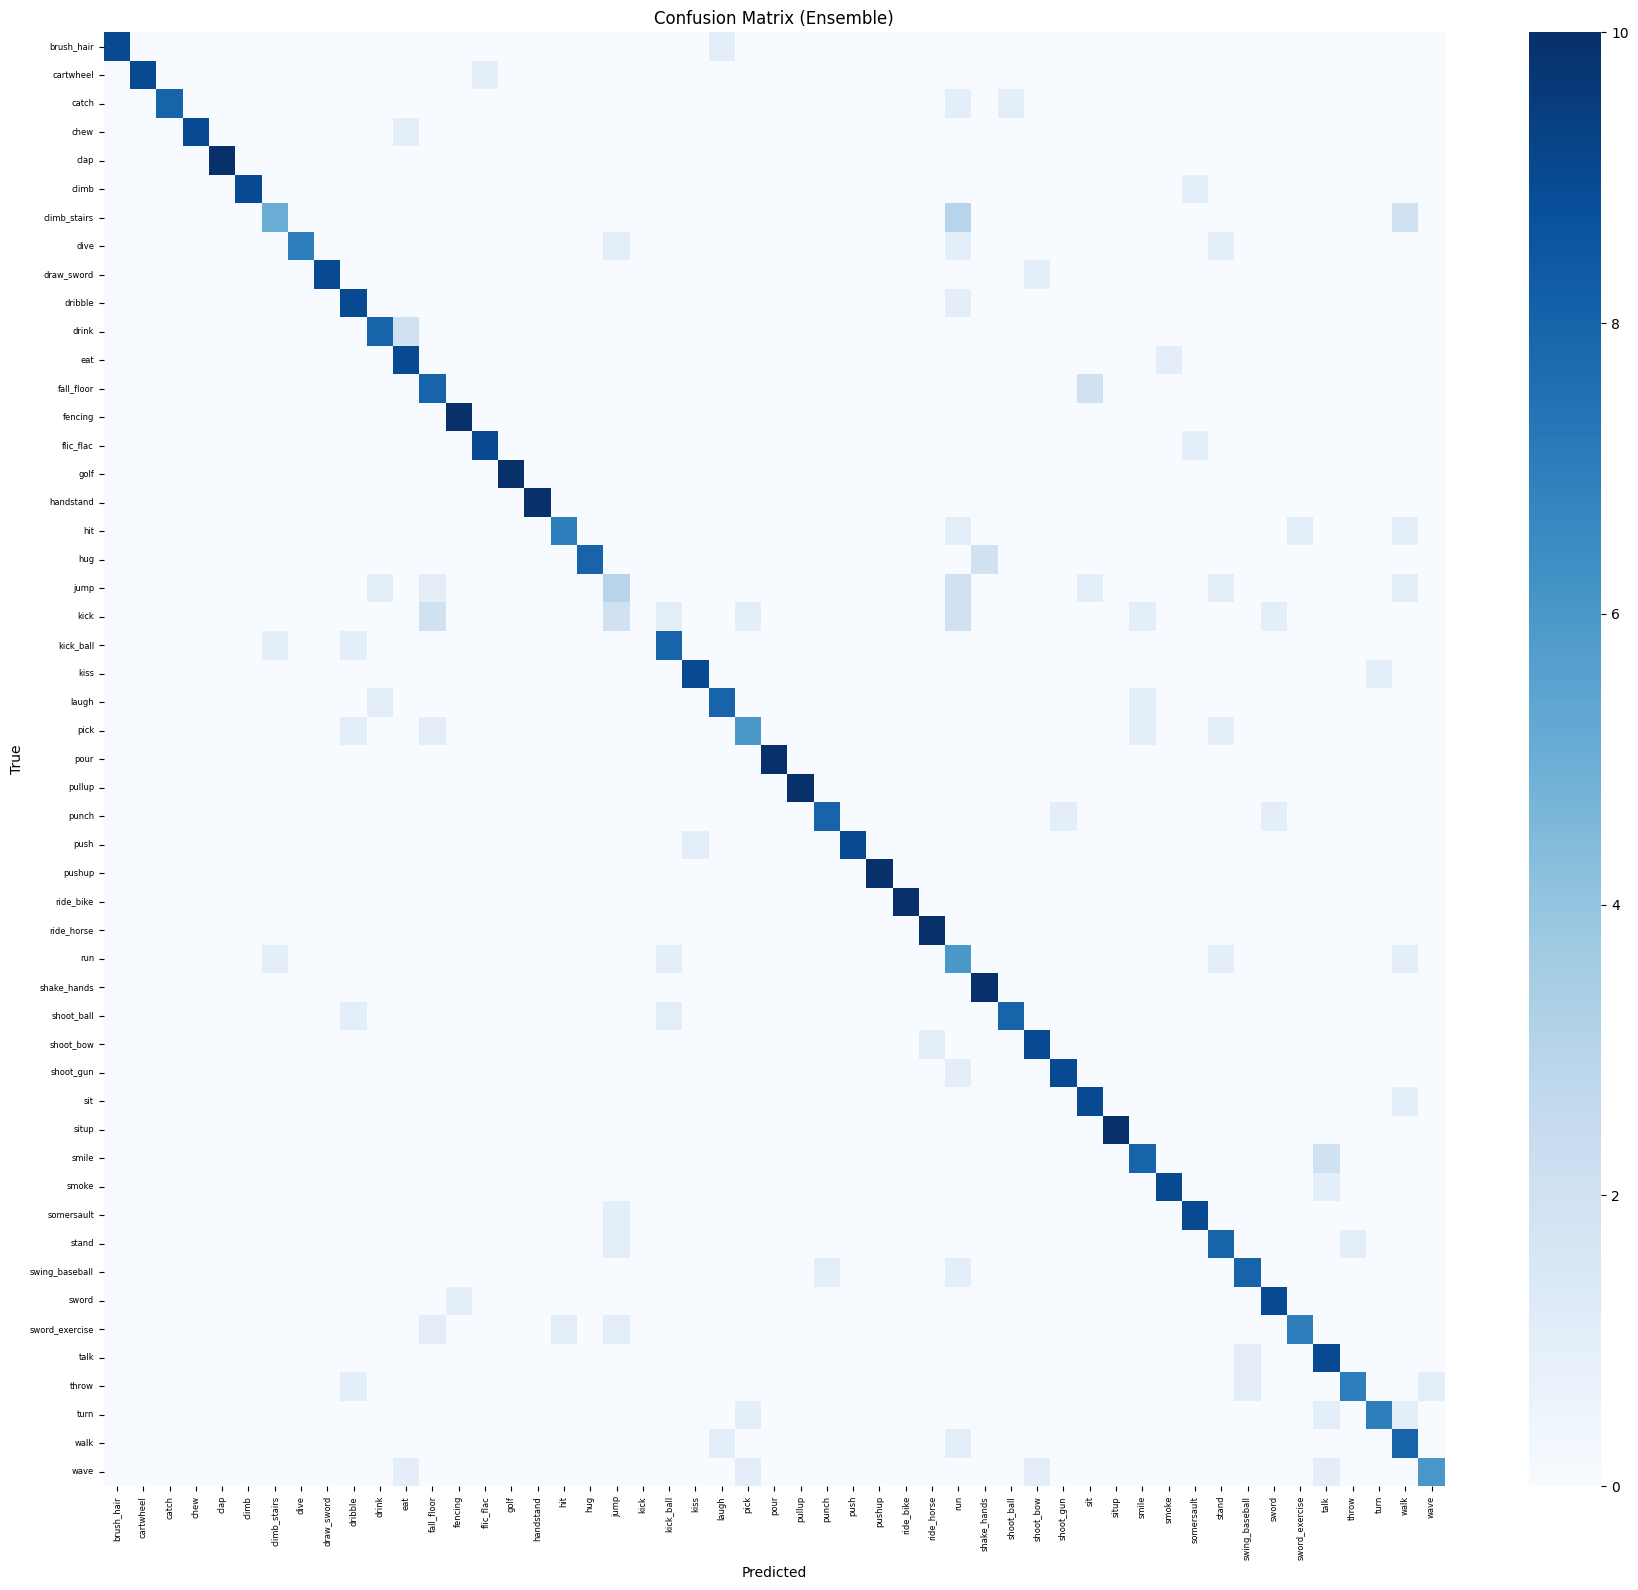

In [38]:
cm = confusion_matrix(all_true, preds_ensemble, labels=MAIN_CLASSES)
plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=False, cmap='Blues', xticklabels=MAIN_CLASSES, yticklabels=MAIN_CLASSES)
plt.xlabel('Predicted'); plt.ylabel('True')
plt.title('Confusion Matrix (Ensemble)')
plt.xticks(rotation=90, fontsize=6); plt.yticks(fontsize=6)
plt.tight_layout(); plt.savefig('confusion_matrix.png', dpi=150); plt.show()

## 16. Prediction Distribution

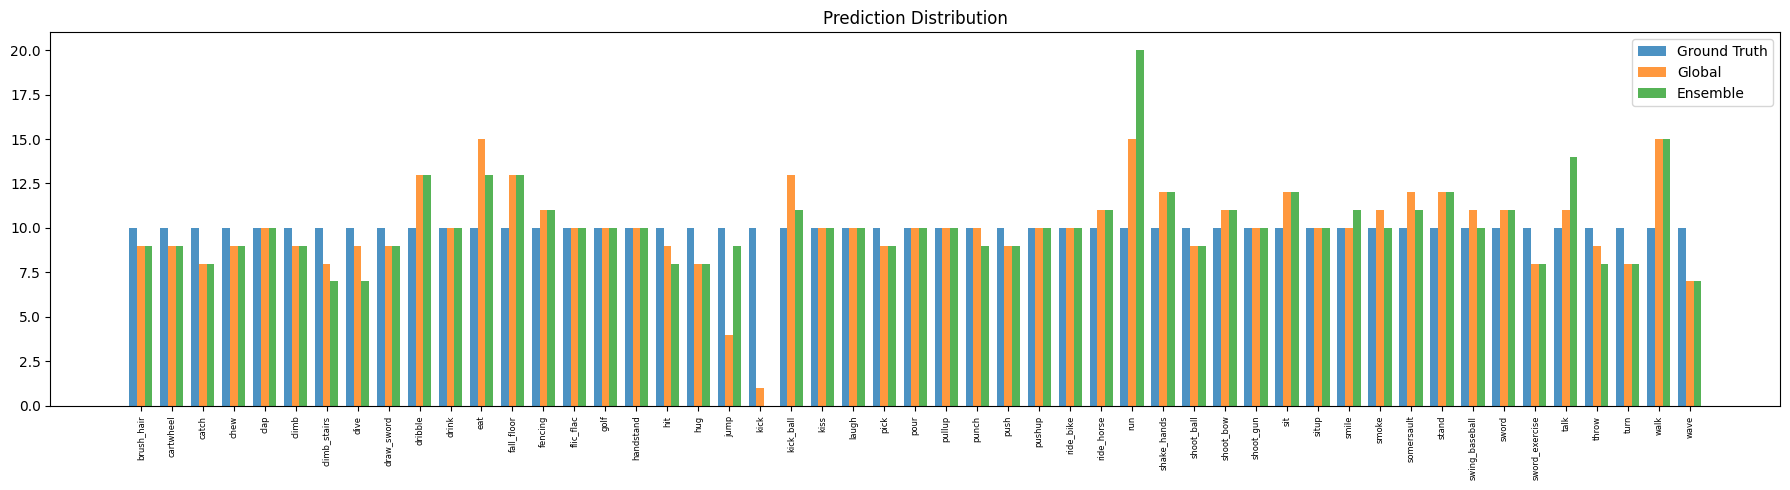

In [39]:
gt_cnt = Counter(all_true)
pg_cnt = Counter(preds_global)
pe_cnt = Counter(preds_ensemble)

cls_sorted = sorted(MAIN_CLASSES, key=lambda x: gt_cnt.get(x,0), reverse=True)
x = np.arange(len(cls_sorted))
w = 0.25

fig, ax = plt.subplots(figsize=(18, 5))
ax.bar(x-w, [gt_cnt.get(c,0) for c in cls_sorted], w, label='Ground Truth', alpha=0.8)
ax.bar(x, [pg_cnt.get(c,0) for c in cls_sorted], w, label='Global', alpha=0.8)
ax.bar(x+w, [pe_cnt.get(c,0) for c in cls_sorted], w, label='Ensemble', alpha=0.8)
ax.set_xticks(x); ax.set_xticklabels(cls_sorted, rotation=90, fontsize=6)
ax.legend(); ax.set_title('Prediction Distribution')
plt.tight_layout(); plt.savefig('pred_distribution.png', dpi=150); plt.show()

## 17. Final Summary

In [40]:
print('='*60)
print('FINAL SUMMARY')
print('='*60)
print(f'Specialist A: {SPECIALIST_A_TARGETS}')
print(f'Specialist B: {SPECIALIST_B_TARGETS}')
print(f'Fusion Weight: {FUSION_WEIGHT}')
print(f'\nGlobal Accuracy:   {acc_g*100:.2f}%')
print(f'Ensemble Accuracy: {acc_e*100:.2f}%')
print(f'Improvement:       {(acc_e-acc_g)*100:+.2f}%')
print('='*60)

FINAL SUMMARY
Specialist A: ['jump', 'run', 'climb_stairs']
Specialist B: ['smile', 'talk', 'laugh']
Fusion Weight: 1.0

Global Accuracy:   82.94%
Ensemble Accuracy: 82.35%
Improvement:       -0.59%
